In [1]:
import visual_behavior_glm.GLM_visualization_tools as gvt
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior_glm.glm import GLM
from visual_behavior.data_access import loading
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## load the most recent events model, v15, as well as the most recent dff model, v12, for comparison

In [4]:
versions = [
    '12_dff_L2_optimize_by_session',
    '15_events_L2_optimize_by_session'
]
results = {}
for version in versions:
    t0 = time.time()
    results[version] = gat.retrieve_results({'glm_version':version})
    print('loading results for {} took {} seconds'.format(version, time.time() - t0))

loading results for 12_dff_L2_optimize_by_session took 38.592479944229126 seconds
loading results for 15_events_L2_optimize_by_session took 35.92705297470093 seconds


In [5]:
len(results['15_events_L2_optimize_by_session'])

66276

In [6]:
colors = gvt.project_colors()

# Make a histogram of variance explaine across all cells

<IPython.core.display.Javascript object>


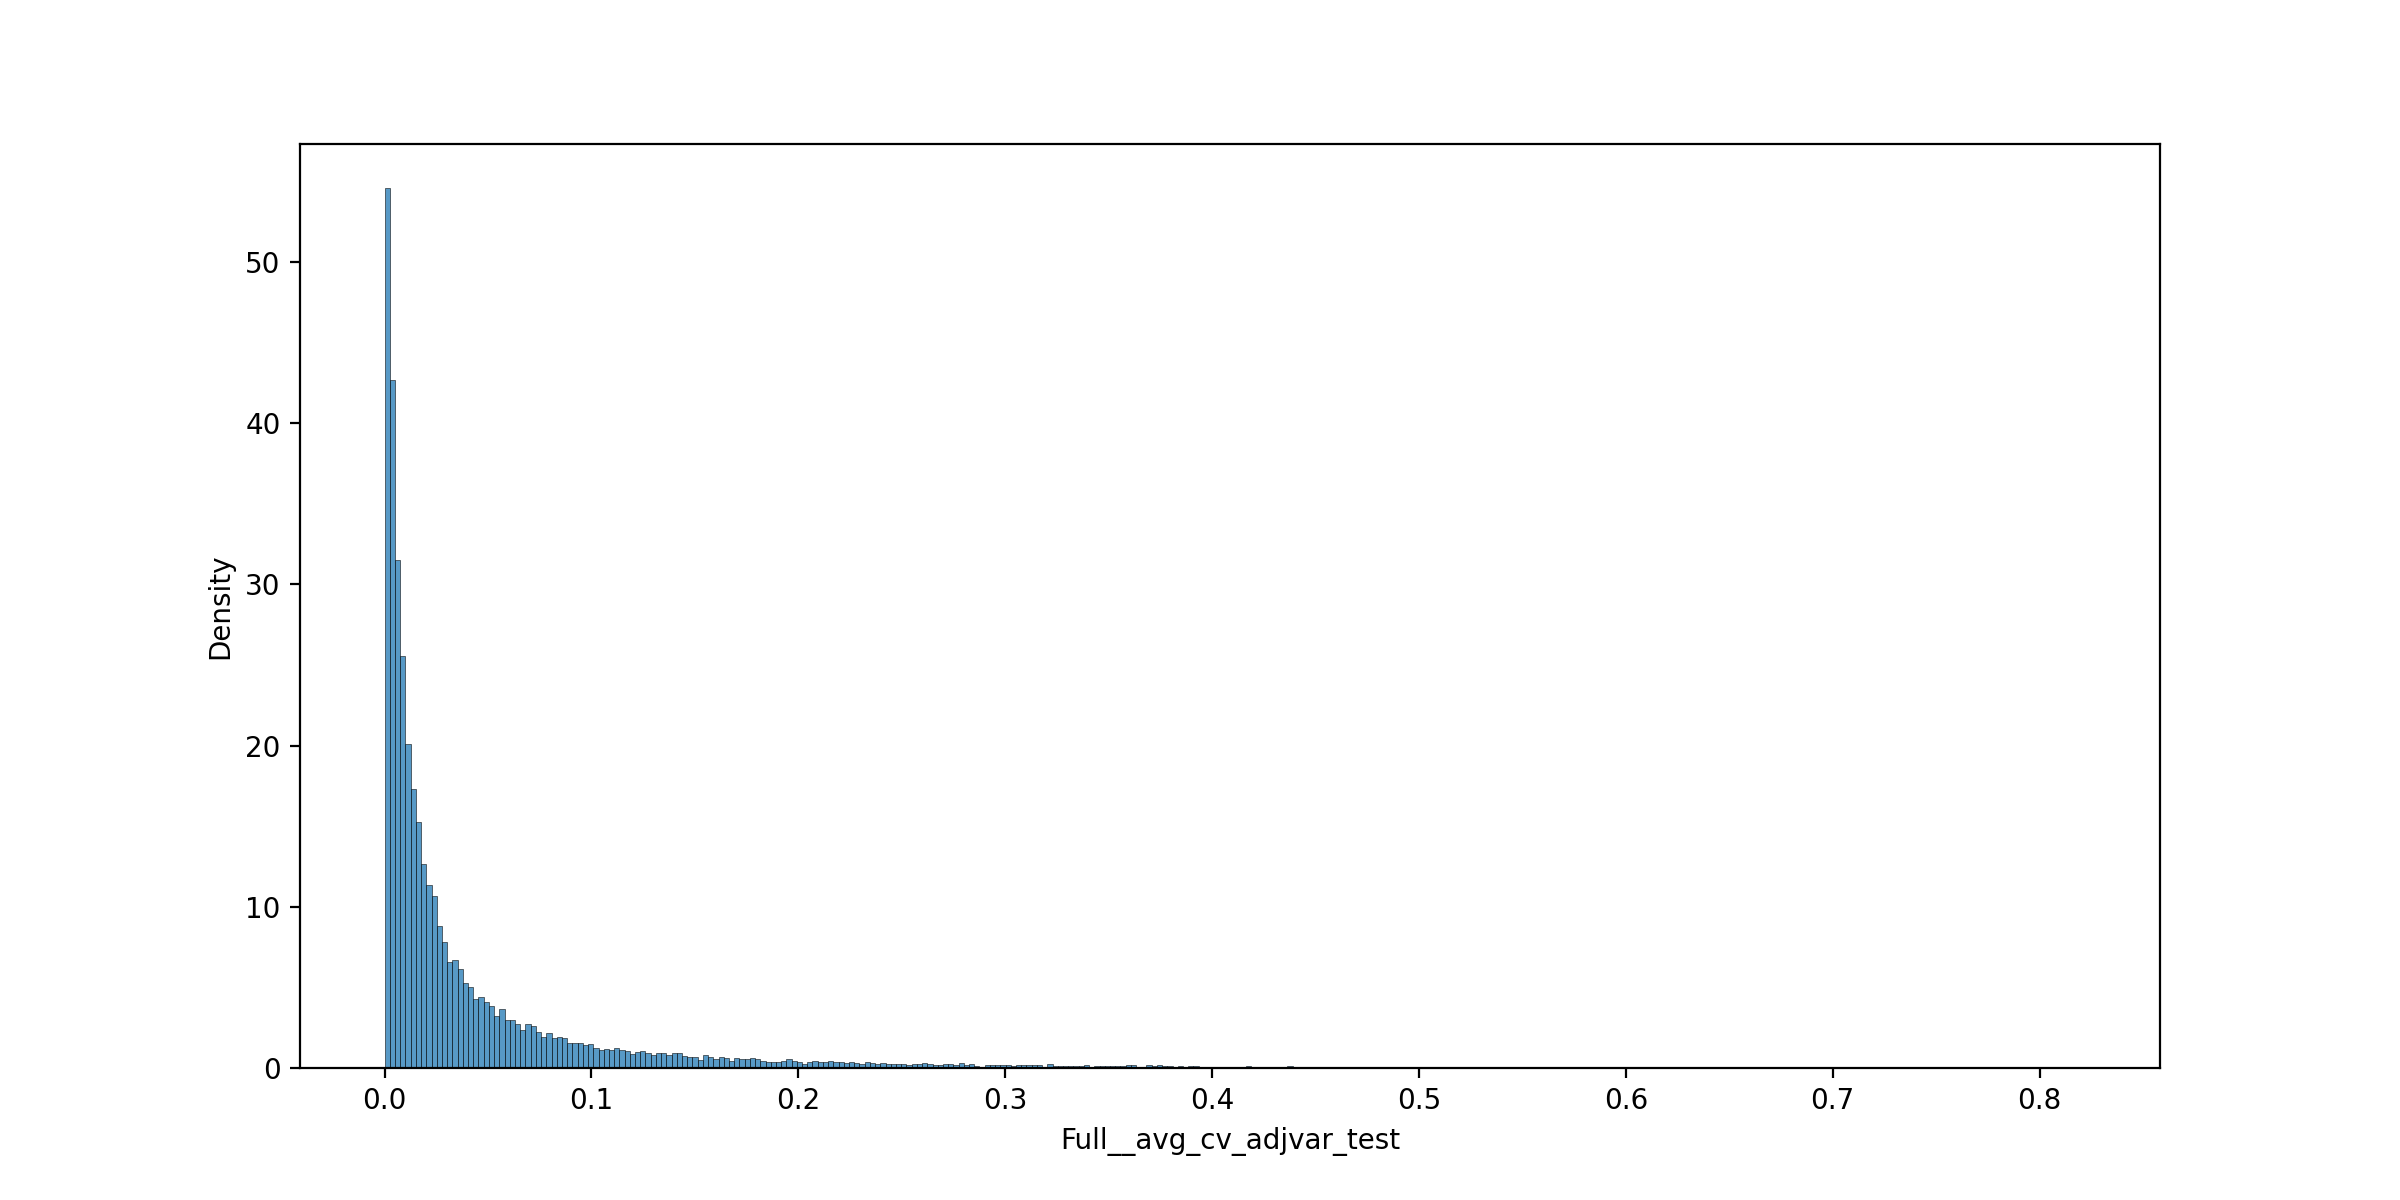

<AxesSubplot:xlabel='Full__avg_cv_adjvar_test', ylabel='Density'>

In [18]:
fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(
    data = results['15_events_L2_optimize_by_session'].query('Full__avg_cv_adjvar_test>0'),
    x = 'Full__avg_cv_adjvar_test',
    stat = 'density',
)

<IPython.core.display.Javascript object>


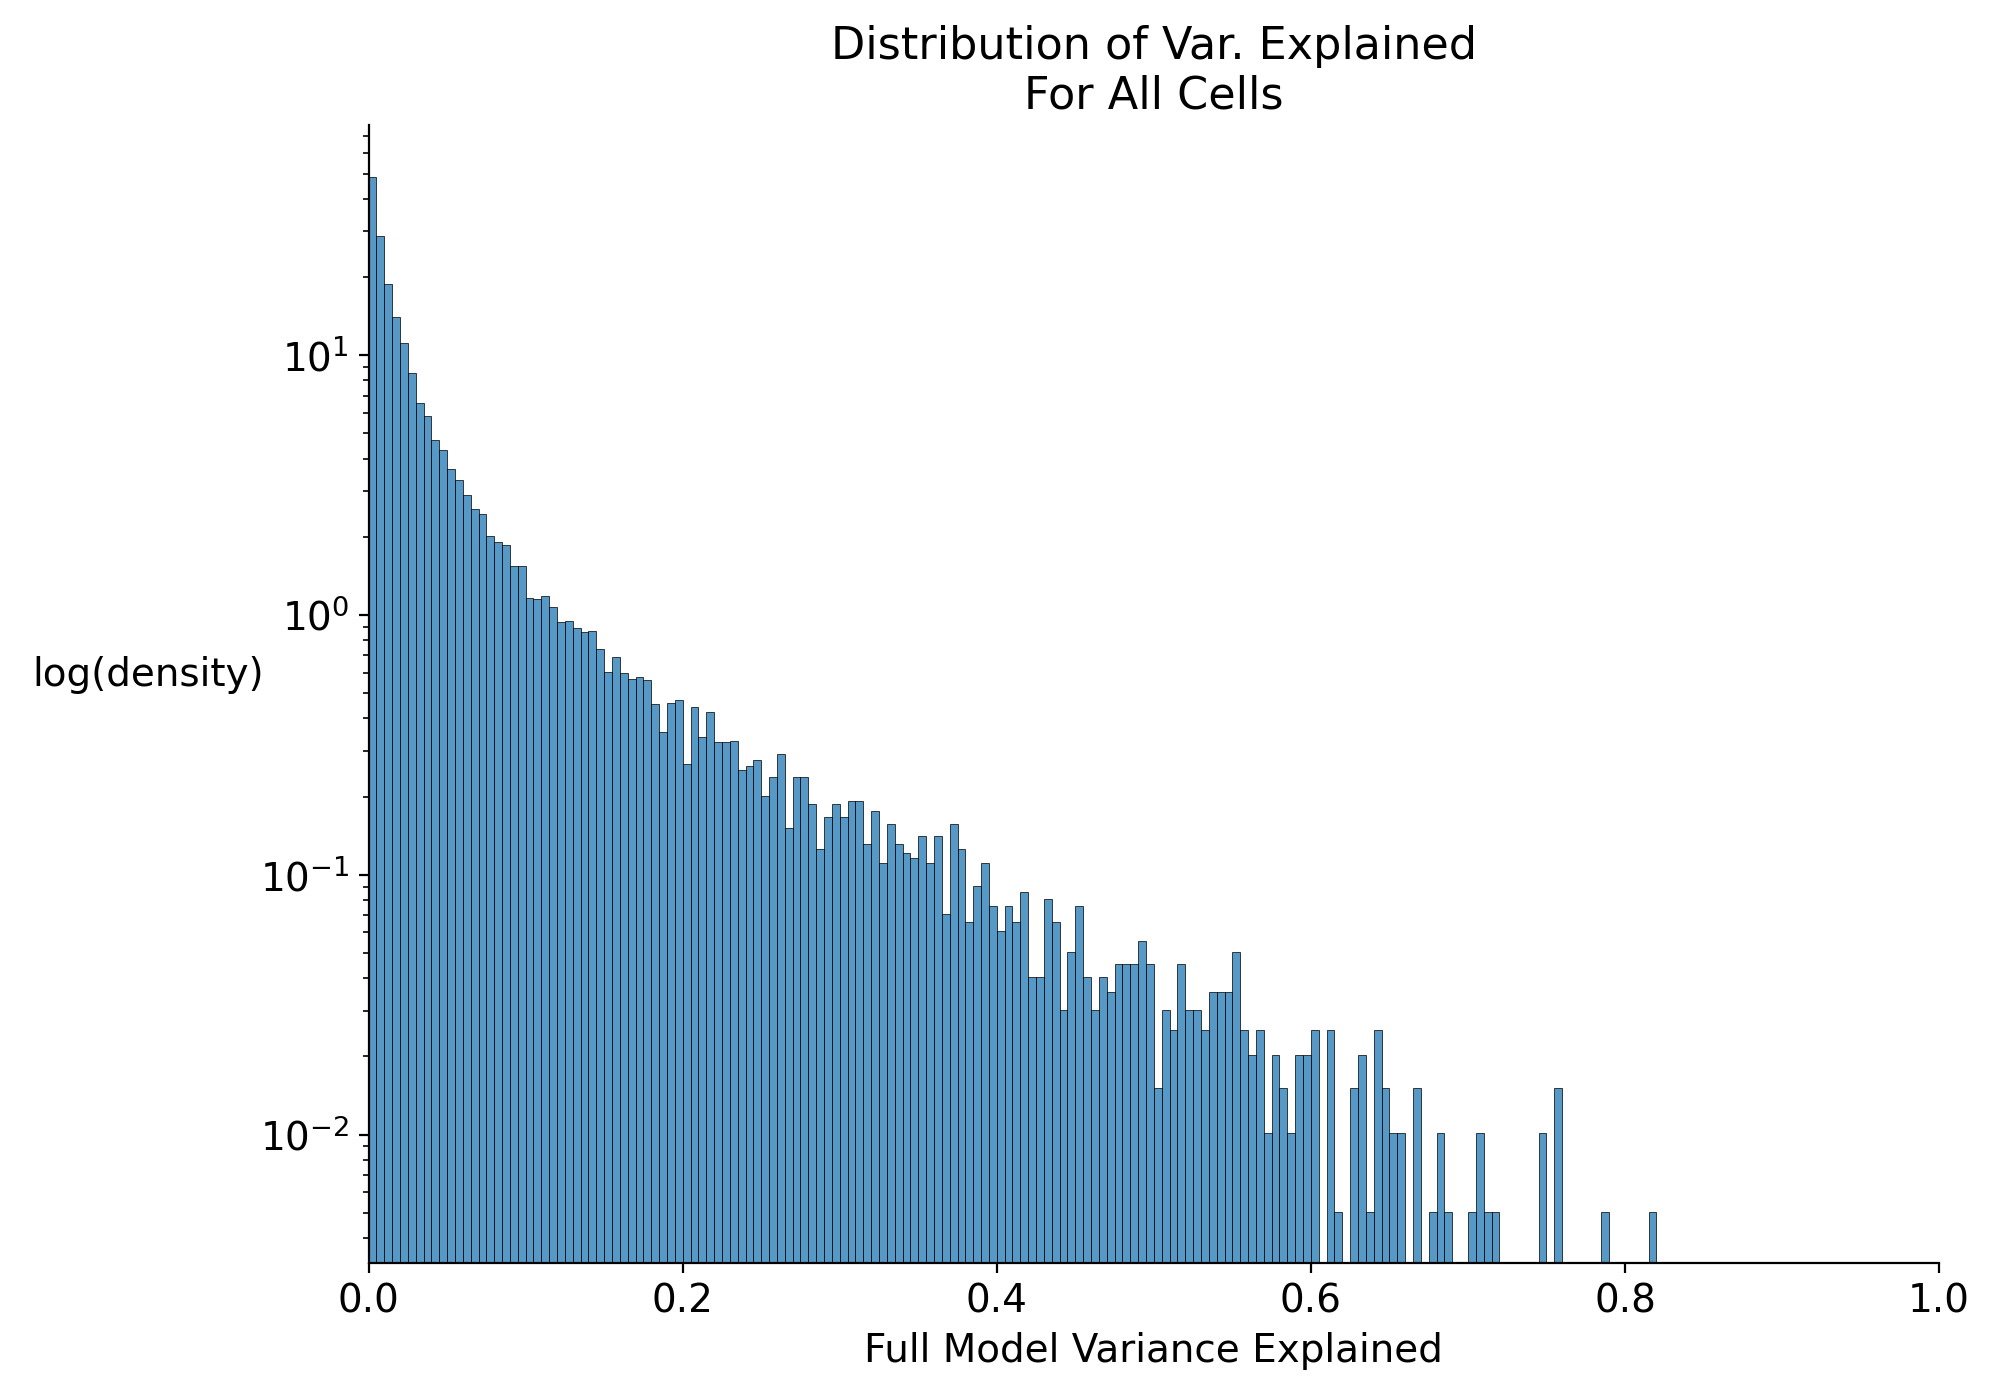

In [19]:
fig, ax = plt.subplots(figsize = (10,7))
sns.histplot(
    data = results['15_events_L2_optimize_by_session'].query('Full__avg_cv_adjvar_test>0'),
    x = 'Full__avg_cv_adjvar_test',
    stat = 'density',
    log_scale=[False, True],
    bins = np.arange(0, 1, 0.005)
)
sns.despine()
ax.set_ylabel('log(density)', rotation = 0, labelpad=40, fontsize=14)
ax.set_xlabel('Full Model Variance Explained', rotation = 0, fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlim(0, 1)
ax.set_title('Distribution of Var. Explained\nFor All Cells', fontsize = 16)

fig.tight_layout()

# Make a box/whisker plot by cre-line

<IPython.core.display.Javascript object>


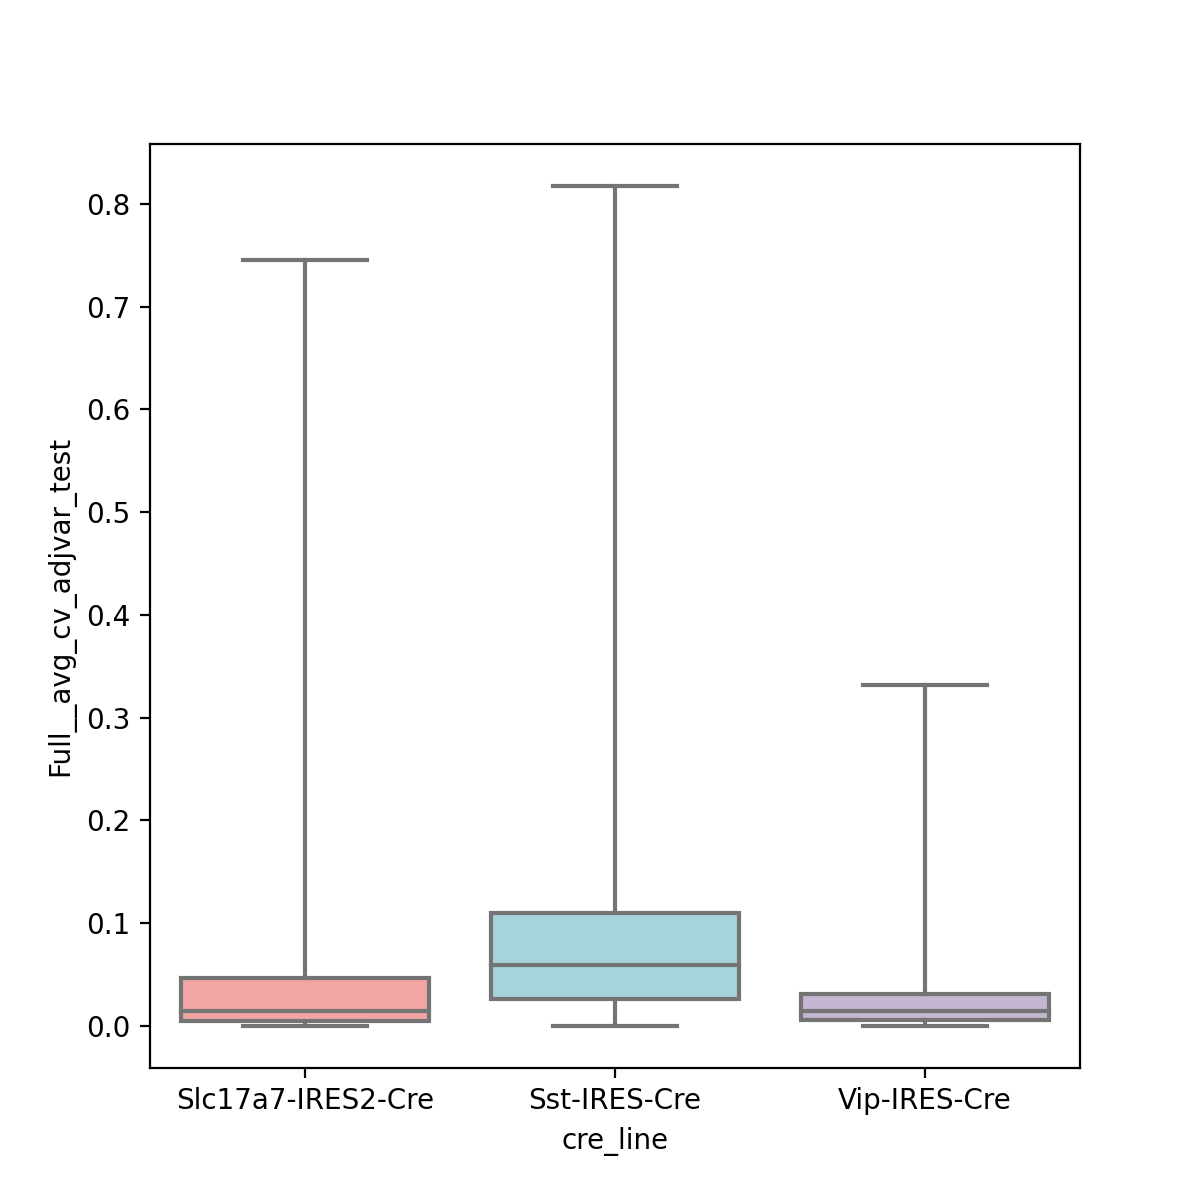

<AxesSubplot:xlabel='cre_line', ylabel='Full__avg_cv_adjvar_test'>

In [20]:
fig, ax = plt.subplots(figsize = (6,6))
sns.boxplot(
    data = results['15_events_L2_optimize_by_session'].query('Full__avg_cv_adjvar_test>0'),
    x = 'cre_line',
    y = 'Full__avg_cv_adjvar_test',
    order = np.sort(results['15_events_L2_optimize_by_session']['cre_line'].unique()),
    whis = np.inf,
    palette = [colors[cre_line] for cre_line in np.sort(results['15_events_L2_optimize_by_session']['cre_line'].unique())]
)

In [21]:
results['15_events_L2_optimize_by_session'].groupby('cre_line')['Full__avg_cv_adjvar_test'].describe()

,count,mean,std,min,25%,50%,75%,max
cre_line,,,,,,,,
Slc17a7-IRES2-Cre,56318.0,0.025898,0.063221,0.0,0.000000,0.002192,0.019731,0.745434
Sst-IRES-Cre,2689.0,0.076581,0.102690,0.0,0.012568,0.047949,0.098973,0.817334
Vip-IRES-Cre,7241.0,0.016869,0.028572,0.0,0.000000,0.005928,0.021317,0.332095


In [22]:
pd.DataFrame(results['15_events_L2_optimize_by_session']['Full__avg_cv_adjvar_test'].describe()).rename(columns={'Full__avg_cv_adjvar_test': 'Variance Explained'})

,Variance Explained
count,66248.000000
mean,0.026968
std,0.063458
min,0.000000
25%,0.000000
50%,0.003059
75%,0.022623
max,0.817334


## identify a sample session to use to plot the fits for some cells vs actual data
Note: the OEID selected was 963391867. If a future run of this notebook results in a different random OEID, the corresponding cell_specimen_ids used below will no longer work.

In [23]:
passive_sessions = ['OPHYS_2_images_A_passive', 'OPHYS_2_images_B_passive', 'OPHYS_5_images_A_passive', 'OPHYS_5_images_B_passive']
sample = results['15_events_L2_optimize_by_session'].query('Full__avg_cv_adjvar_test > 0.5 and session_type not in @passive_sessions').sample(random_state=1)
sample[['Full__avg_cv_var_test', 'cell_specimen_id','ophys_experiment_id','session_type','cre_line']]


,Full__avg_cv_var_test,cell_specimen_id,ophys_experiment_id,session_type,cre_line
52150,0.626038,1086492467,963391867,OPHYS_1_images_B,Slc17a7-IRES2-Cre


In [24]:
sample['ophys_experiment_id'].iloc[0]

963391867

## load the model for the selected OEID for both versions. Save into a dict called `glm_dict`

In [14]:
version = '15_events_L2_optimize_by_session'
oeid = sample['ophys_experiment_id'].iloc[0]
glm_dict = {}
for version in versions:
    glm_dict[version] = GLM(
        oeid, 
        version, 
        use_previous_fit=True,  # if True, uses cached fit if available (False by default)
        recompute=True, 
        log_results=False, # if True, logs fit results to mongo database (True by default)
        log_weights=False, # if True, logs weights to mongo database (True by default)
        NO_DROPOUTS=True, # if True, does not perform dropout analysis (False by default)
        TESTING=False, # if True, fits only the first 6 cells in the experiment (False by default)
    )

importing GLM_fit_tools from /allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_12_dff_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py
loading previous fit...
    Adding kernel: intercept
    Adding kernel: time
    Adding kernel: licks


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
Error encountered while adding kernel for passive_change. Attemping to continue without this kernel. 
Passive Change kernel cant be added to active sessions


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:227: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-08 20:14:36+00:00) for behavior session (963227578) deviates by more than an hour from the `start_time` (2019-10-08 13:34:36.614000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_916634005/behavior_session_963227578/963166572.pkl
  "The `date_of_acquisition` field in LIMS "


    Adding kernel: false_alarms
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_12_dff_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:745: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/.local/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid va

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: face_motion_PC_0


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_0. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_1


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_1. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_2


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_2. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_3


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_3. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_4


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_4. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
    Adding kernel: model_bias
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_task0
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_omissions1
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_timing1D
                 : Mean Centering
                 : Standardized to unit variance
The following kernels failed to be added to the model: 
{'passive_change', 'face_motion_PC_0', 'face_motion_PC_1', 'face_motion_PC_4', 'face_mot

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
Error encountered while adding kernel for passive_change. Attemping to continue without this kernel. 
Passive Change kernel cant be added to active sessions


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:227: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-08 20:14:36+00:00) for behavior session (963227578) deviates by more than an hour from the `start_time` (2019-10-08 13:34:36.614000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_916634005/behavior_session_963227578/963166572.pkl
  "The `date_of_acquisition` field in LIMS "


    Adding kernel: false_alarms
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_15_events_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:745: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/.local/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:684: RuntimeWarning: invalid

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: face_motion_PC_0


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_0. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_1


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_1. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_2


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_2. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_3


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_3. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'


ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'


    Adding kernel: face_motion_PC_4


ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen driver line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.io.lims_database:cannot query specimen reporter line: can't adapt type 'numpy.int64'
ERROR:visual_behavior.ophys.sync.process_sync:Sync photodiode error needs to be fixed. Using assumed monitor delay: 0.0351


Error encountered while adding kernel for face_motion_PC_4. Attemping to continue without this kernel. 
'VisualBehaviorOphysProjectCache' object has no attribute 'get_experiment_table'
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
    Adding kernel: model_bias
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_task0
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_omissions1
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_timing1D
                 : Mean Centering
                 : Standardized to unit variance
The following kernels failed to be added to the model: 
{'passive_change', 'face_motion_PC_0', 'face_motion_PC_1', 'face_motion_PC_4', 'face_mot

In [25]:
versions

['12_dff_L2_optimize_by_session', '15_events_L2_optimize_by_session']

In [26]:
glm_dict[versions[0]].session.metadata

{'equipment_name': 'CAM2P.4',
 'sex': 'M',
 'age_in_days': 139,
 'stimulus_frame_rate': 60.0,
 'session_type': 'OPHYS_1_images_B',
 'date_of_acquisition': Timestamp('2019-10-08 20:14:36+0000', tz='UTC'),
 'reporter_line': 'Ai93(TITL-GCaMP6f)',
 'indicator': 'GCaMP6f',
 'cre_line': 'Slc17a7-IRES2-Cre',
 'behavior_session_uuid': UUID('746dfcd1-536a-4be0-b4da-26d5f830db3b'),
 'driver_line': ['Camk2a-tTA', 'Slc17a7-IRES2-Cre'],
 'mouse_id': 479458,
 'full_genotype': 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'behavior_session_id': 963227578,
 'emission_lambda': 520.0,
 'excitation_lambda': 910.0,
 'experiment_container_id': 957361481,
 'field_of_view_height': 512,
 'field_of_view_width': 451,
 'imaging_depth': 375,
 'imaging_plane_group': None,
 'imaging_plane_group_count': 0,
 'ophys_experiment_id': 963391867,
 'ophys_frame_rate': 31.0,
 'ophys_session_id': 963166572,
 'project_code': 'VisualBehaviorTask1B',
 'targeted_structure': 'VISp'}

In [27]:
glm = glm_dict[versions[0]]
glm.session.licks

,timestamps,frame
0,10.97364,256
1,11.12371,265
2,11.32392,277
3,11.60741,294
4,14.02604,439
...,...,...
2579,4205.06059,251693
2580,4205.34420,251710
2581,4206.02807,251751
2582,4206.21155,251762


<IPython.core.display.Javascript object>


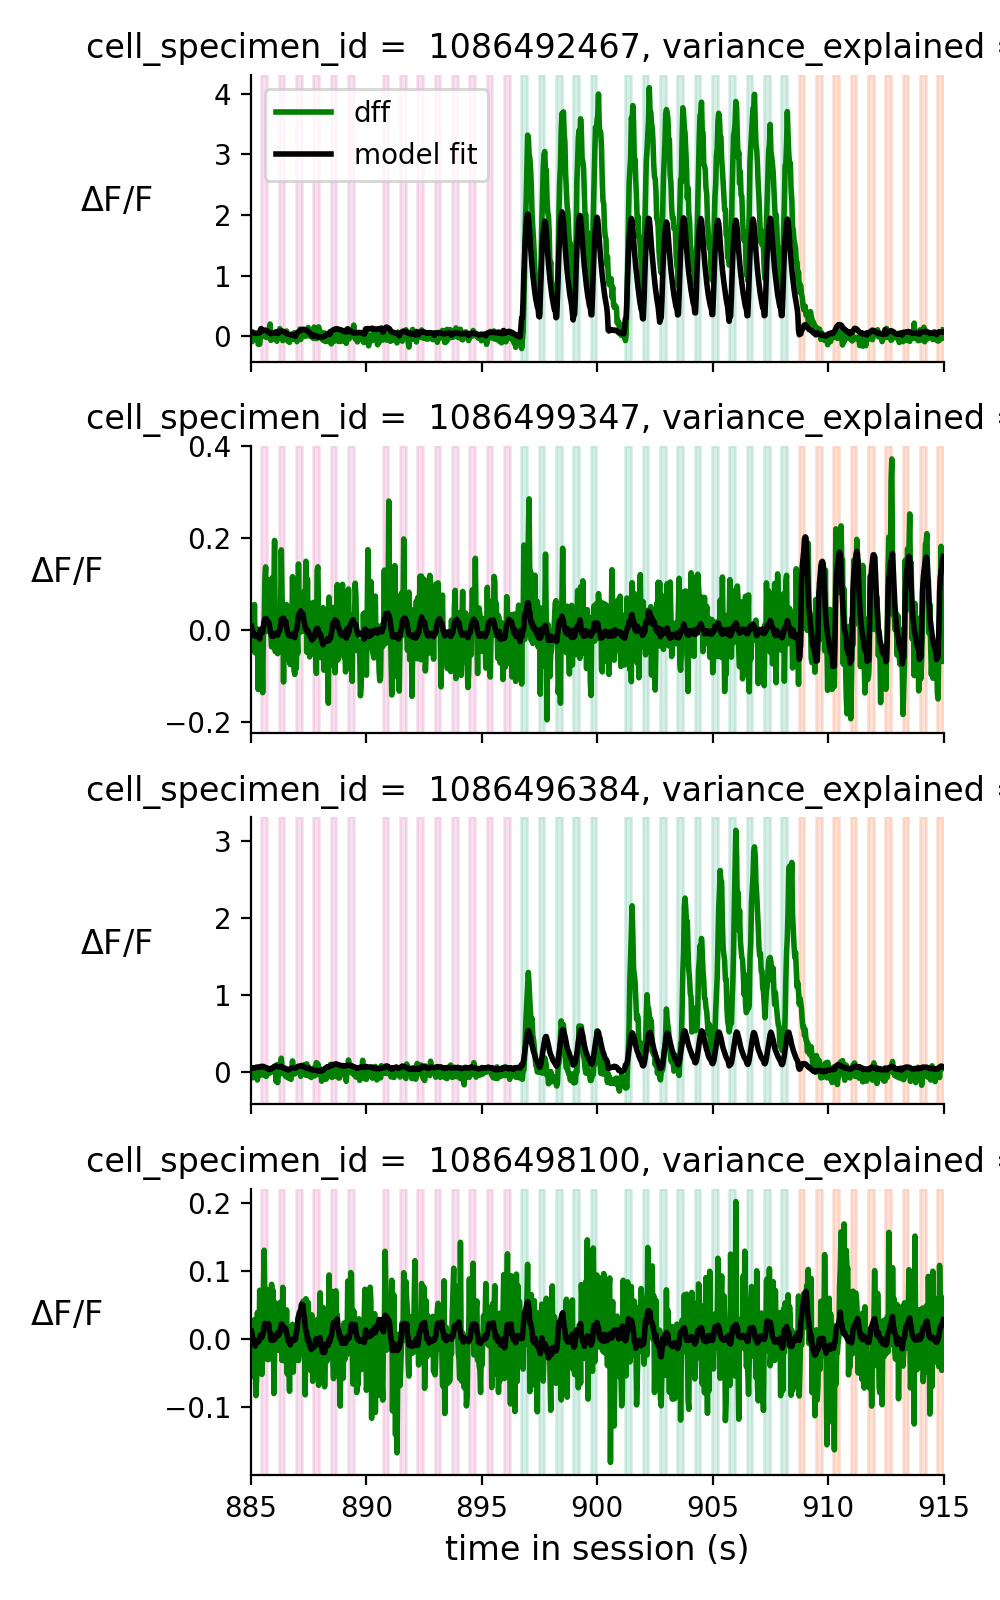

In [34]:
fig, ax = gvt.plot_sample_cells(
    glm_dict[versions[0]], 
    cell_specimen_ids = [1086492467, 1086499347, 1086496384, 1086498100], 
    t0 = 885,
    t1 = 915,
    figwidth=5,
    height_per_cell=2
)

<IPython.core.display.Javascript object>


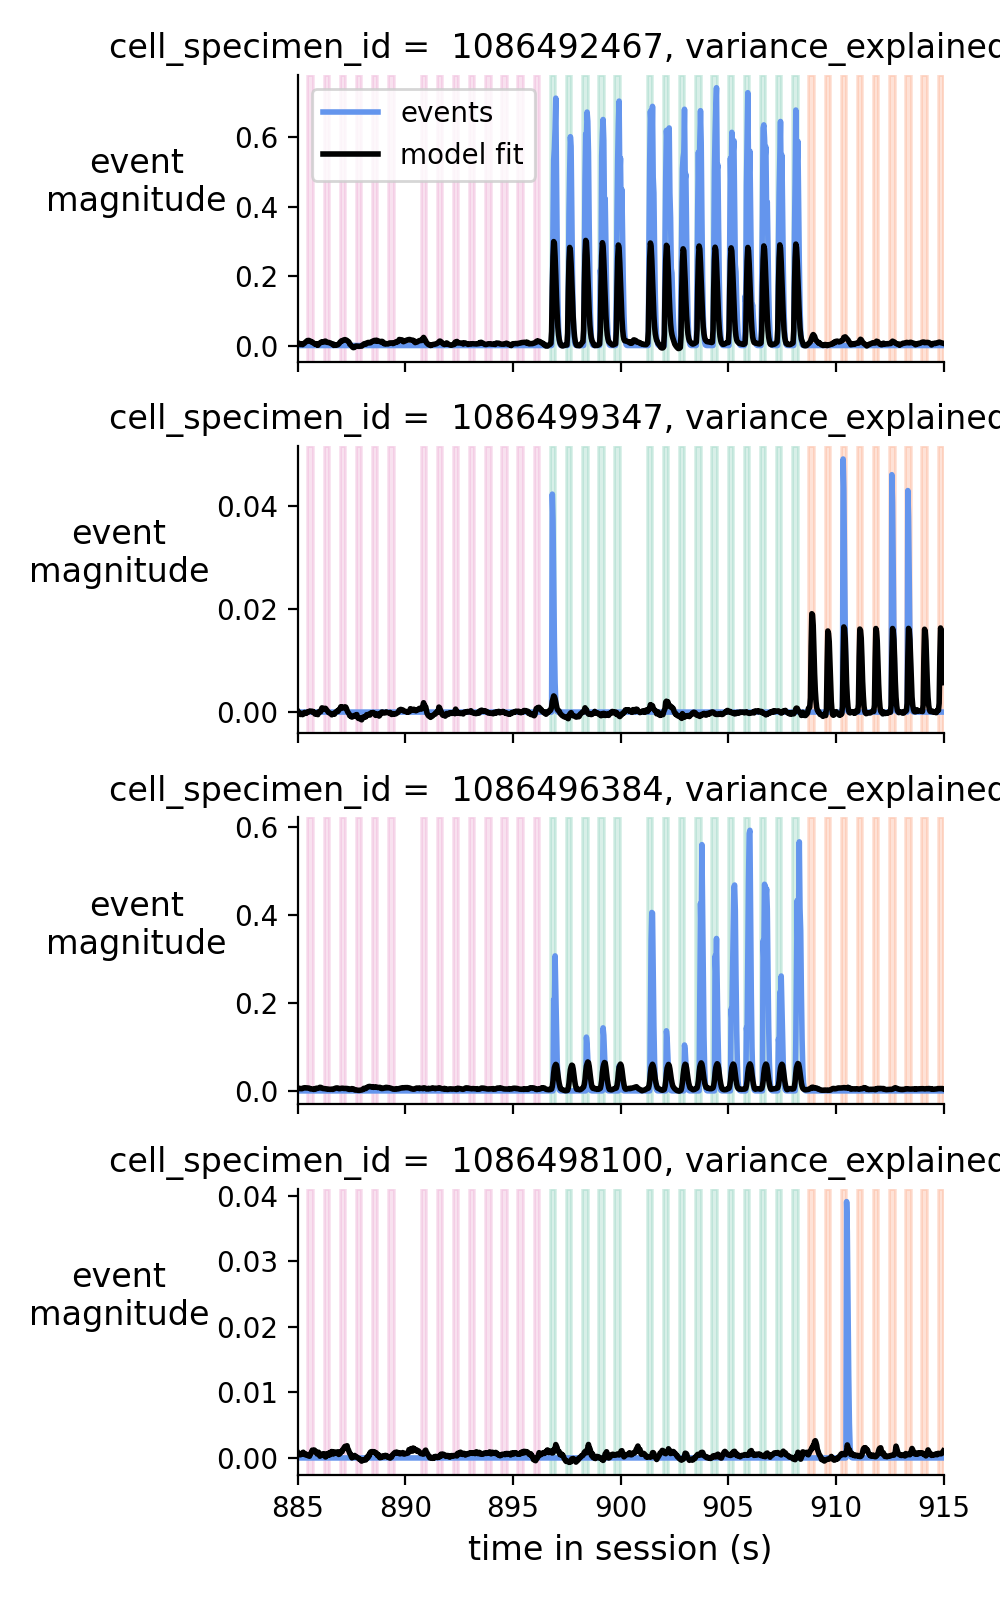

In [35]:
fig, ax = gvt.plot_sample_cells(
    glm_dict[versions[1]],
    cell_specimen_ids = [1086492467, 1086499347, 1086496384, 1086498100], 
    t0 = 885,
    t1 = 915,
    figwidth=5,
    height_per_cell=2
)